# **Introduction to In-Context Learning Demo: Using LLMs as Numerical Optimizers**

This notebook provides a step-by-step walkthrough to demonstrate the capabilities of LLMs as Numerical Optimizers. In one of the previous works of the lab: *[SAS Prompt](https://arxiv.org/pdf/2504.20459)* (Ben Amor et al., 2025), we show that LLMs have a built-in ability to perform (stochastic) numerical optimization and that this property can be leveraged for explainable robot policy search. In this tutorial we would be optimizing 1D Function and 2D Ackley using Gemini 2.0/2.5 Flash.

# **Overview**
This demonstration guides you through:
- **Part 1**: Optimizing 1D Ackley Functions using Gemini, compare to Adam's optimization process and visualize the difference in the optimization process.
- **Part 2**: Optimizing 2D Ackley Functions using Gemini, compare to Adam's optimization process and visualize the difference in the optimization process.
- **Part 3**: Comparing Both 1D and 2D Ackley Optimizations using Gemini and other baselines.

The result contains clear visualizations of how LLMs can behave as gradient-free numerical optimizers, and how they compare to traditional approaches.

# **Background**
This demo adapts one key concept from the SAS-Prompt methodology presented in the original work(Ben Amor et al., 2025):
1. LLMs as Numerical Optimizers: the SAS-Prompt paper shows that LLMs can perform global optimization on functions such as Ackley and Rastrigin—using no derivative information—by proposing successive candidate values and adjusting based on observed outcomes. This emergent ability enables gradient-free policy search directly inside the LLM.

**Why This Is Interesting**

Just as the original paper demonstrates numerical optimization without explicit reward functions or gradient updates, this demo shows that:

1. The LLM infers parameter–behavior relationships (a textual gradient)

2. Optimization happens entirely through language(prompting) + numbers

3. The LLM reasons and synthesizes without external training

This setup benchmarks the LLM’s ability to conduct explainable, in-context, and iterative optimization based solely on observed results.

##  **Let's take a look at two examples (1D & 2D Numerical Optimization)**

The following animations visualize the LLM-based optimization process. We notice how the LLM gradually moves the current best estimate closer and closer to the global minimum. Our results indicate that this LLM-based numerical optimization is competitive with standard optimization algorithms (Adam, Nelder-Mead, GD) in low-dimensional settings (up to 8 dimensions studied in the paper). (Ben Amor et al., 2025)


### **1D Ackley Numerical Optimization**

This first animation displays Part 1 of the demo, using a LLM to optimize a 1D Ackley Function, here we can notice how the LLM gradually moves its best estimate closer and closer to the global minimum.

<img src="https://raw.githubusercontent.com/intro-to-icl/intro-to-icl.github.io/refs/heads/master/static/images/1d_optimization.gif" height="500">

### **2D Ackley Numerical Optimization**

This second animation displays Part 2 of the demo, using a LLM to optimize a 2D Ackley Function, here we can notice how the LLM gradually moves its best estimate closer and closer to the global minimum.

<img src="https://raw.githubusercontent.com/intro-to-icl/intro-to-icl.github.io/refs/heads/master/static/images/numerical_optimization.gif" height="500">

## **LLM as the Optimizer**

As in the original SAS prompt experiments, we use Gemini 2.0/2.5 Flash, ensuring behavior consistent with pattern-based, gradient-free optimization rather than explicit symbolic reasoning.

The workflow follows the Numerical Optimization section in the SAS-Prompt paper.

## **Code Overview**
The implementation is organized into a modular structure, with each component responsible for a different stage of the numerical optimization pipeline. This design separates data generation, visualization, prompt construction, LLM inference, and result interpretation, making the system easy to understand, modify, and extend.

## **Before Running the Demo, Follow the Instructions Below**
To run the full experiment:
1. Ensure all dependencies are imported and installed.
2.	Visit Google AI Studio (https://aistudio.google.com/) to obtain your Gemini API key.
3.	Once API key is generated, copy and paste it into the demo when prompted.

#### **If having trouble creating an API Key, follow the link below for instructions:**
* #### **[Instructions on How to Obtain a Gemini API Key](https://docs.google.com/document/d/17pgikIpvZCBgcRh4NNrcee-zp3Id0pU0vq2SG52KIGE/edit?usp=sharing)**



In [ ]:
#@title **Import Necessary Libraries**
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.optim as optim
import numpy as np
from google import genai
import matplotlib.colors as mcolors
import matplotlib.cm as cm
import json
import random
import time
import re
from scipy.optimize import minimize
from google.genai import types
import getpass
import ipywidgets as widgets

In [ ]:
#@title **Setting Up Gemini Client**
apikey = getpass.getpass("Enter your Gemini API Key: ")
client = genai.Client(api_key=apikey)

Enter your Gemini API Key: ··········


In [ ]:
#@title **Choose a Model**
model_dropdown = widgets.Dropdown(
    options=[
        ("Gemini 2.5 Flash", "gemini-2.5-flash"),
        ("Gemini 2.0 Flash", "gemini-2.0-flash")
    ],
    description="Model:",
    value="gemini-2.5-flash",
    style={'description_width': 'initial'}
)

confirm_button = widgets.Button(
    description="Confirm Selection"
)

output = widgets.Output()

model_name = None

def on_confirm_click(b):
    global model_name, batch_size

    model_name = model_dropdown.value

    with output:
        output.clear_output()
        print(f"\nSelected model: {model_name}")

confirm_button.on_click(on_confirm_click)

display(model_dropdown, confirm_button, output)

Dropdown(description='Model:', options=(('Gemini 2.5 Flash', 'gemini-2.5-flash'), ('Gemini 2.0 Flash', 'gemini…

Button(description='Confirm Selection', style=ButtonStyle())

Output()

The cell below `Numerical Function Definitions` defines the two benchmark functions used in this numerical optimization demo.
- 1D variant of the Ackley function. It produces a non-convex landscape with a mixture of exponential, oscillatory, and quadratic behavior, making it useful for testing how optimization methods handle multiple local minima in one dimension.
- A shifted 2D Ackley function. By allowing horizontal and vertical shifts (and an optional vertical offset), it lets you reposition the global minimum and modify the landscape. The 2D Ackley is a classic stress-test function for global optimizers because of its many local minima surrounding a central basin.

In [ ]:
#@title **Numerical Function Definitions**
def one_dimensional_function(x):
  return x**2 + 5*torch.sin(2*x)

def shifted_ackley(x, y, h_x=10, h_y=15, c=0):
    """
    Shifted Ackley function.

    This function computes the Shifted Ackley function, a 2D benchmark function
    often used in optimization. It applies horizontal and vertical shifts to the
    standard Ackley function.

    Args:
        x (torch.Tensor): Input tensor for the x-dimension.
        y (torch.Tensor): Input tensor for the y-dimension.
        h_x (float, optional): Horizontal shift value. Defaults to 10.
        h_y (float, optional): Vertical shift value. Defaults to 15.
        c (float, optional): Vertical shift constant. Defaults to 0.

    Returns:
        torch.Tensor: The computed Shifted Ackley function value.
    """
    # Apply horizontal shift
    x_shifted = x - h_x
    y_shifted = y - h_y

    # Compute the original Ackley function with shifted inputs
    term1 = -20 * torch.exp(-0.2 * torch.sqrt(0.5 * (x_shifted**2 + y_shifted**2)))
    term2 = -torch.exp(0.5 * (torch.cos(2 * np.pi * x_shifted) + torch.cos(2 * np.pi * y_shifted)))
    return term1 + term2 + 20 + np.e + c  # Apply vertical shift by adding c

The `Utility Functions` cell provides a set of utility functions that support the numerical optimization demo by handling visualization, text parsing, and initializing baseline model comparisons. The plotting functions (plot_1d and plot_2d) create visualizations that show how an optimizer or LLM moves across the 1D and 2D objective landscapes, overlaying its trajectory on top of the true function surface. These visual tools make it easy to diagnose behavior such as convergence, oscillation, or getting stuck in local minima.

The other help the workflow operate smoothly: small parsing helpers extract numerical values from LLM-generated text, while the included baseline optimizers (Nelder–Mead and gradient descent) provide comparison results to compare against ICL.

In [ ]:
#@title **Utility Functions**
def plot_1d(data_trace, x_range, title):

  x_values = np.linspace(x_range[0], x_range[1], 400)
  t = torch.tensor(x_values, dtype=torch.float32)
  y_values = one_dimensional_function(t).detach().numpy()
  fig, ax = plt.subplots(figsize=(8, 6), dpi=120)
  ax.plot(x_values, y_values, color='black', label='f(x)', zorder=1, lw=2)
  colors = plt.cm.viridis(np.linspace(0, 1, len(data_trace)))

  for step, pt in enumerate(data_trace):
    ax.scatter(pt[0], pt[1], s=130, color=colors[step], marker='o', zorder=2+step)

  ax.set_title(f'{title}')
  ax.set_xlabel('x')
  ax.set_ylabel('f(x)')
  ax.legend()
  norm = mcolors.Normalize(vmin=0, vmax=len(data_trace))
  sm = cm.ScalarMappable(cmap='plasma', norm=norm)
  sm.set_array([])
  fig.colorbar(sm, ax=ax, label='Step')
  plt.show()


def plot_2d(data_trace, title, elev=20, azim=50, dpi=120, width=10, height=8):
    figsize = (width, height)
    fig = plt.figure(figsize=figsize, dpi=dpi)
    ax = fig.add_subplot(111, projection='3d')
    ax.grid(False)

    x = torch.linspace(0, 20, 500)
    y = torch.linspace(5, 25, 500)
    X, Y = torch.meshgrid(x, y, indexing='ij')
    Z = shifted_ackley(X, Y)


    surf = ax.plot_surface(X.numpy(), Y.numpy(), Z.numpy(), cmap='Blues_r', edgecolor='none', alpha=0.3, zorder=1)
    ax.view_init(elev=elev, azim=azim)

    x_points = np.array([pt[0] for pt in data_trace])
    y_points = np.array([pt[1] for pt in data_trace])
    z_points = np.array([pt[2] for pt in data_trace])
    z_points_above = z_points + 2.5


    cmap_points = cm.plasma
    norm = plt.Normalize(0, len(data_trace))
    point_colors = cmap_points(norm(range(len(data_trace))))
    point_colors[:, -1] = 1.0


    ax.scatter(x_points, y_points, z_points_above, c=point_colors, s=80, depthshade=False, edgecolor='black', linewidth=0.5, zorder=2)
    cmap = cm.plasma
    norm = plt.Normalize(0, len(data_trace) - 1)
    sm = cm.ScalarMappable(norm=norm, cmap=cmap)
    # sm.set_array([])
    cbar = plt.colorbar(sm, ax=ax, pad=0.1, shrink=0.6, aspect=20)
    cbar.set_label('Step')

    ax.set_title(f'{title}')
    ax.set_xlabel('X-axis')
    ax.set_ylabel('Y-axis')
    ax.set_zlabel('Z-axis')

    ax.set_xlim(x.min().item(), x.max().item())
    ax.set_ylim(y.min().item(), y.max().item())
    ax.set_zlim(Z.min().item(), Z.max().item() + 2.5)

    plt.show()

def extract_llm_x(text):
    pattern = r'[-+]?\d*\.\d+|[-+]?\d+'
    match = re.search(pattern, text)
    if match:
        return float(match.group())
    return None

def extract_llm_xy(text):
    pattern = r'x:\s*([-+]?\d*\.\d+|[-+]?\d+).*?y:\s*([-+]?\d*\.\d+|[-+]?\d+)'
    match = re.search(pattern, text)
    if match:
        x_value = float(match.group(1))
        y_value = float(match.group(2))
        return x_value, y_value
    return None, None

def optimize_with_nelder_mead(func, initial_x, max_iter=100):
    # Function to convert tensor calculations for scipy optimization
    def func_wrapper(x):
        if len(initial_x)==2:
          return func(torch.tensor(x[0], dtype=torch.float32), torch.tensor(x[1], dtype=torch.float32)).item()
        else:
          return func(torch.tensor(x[0], dtype=torch.float32)).item()

    result = minimize(func_wrapper, initial_x, method='Nelder-Mead', options={'maxiter': max_iter})
    return result

def optimize_gd(initial_x, func, MAX_STEPS=100, learning_rate=0.005):
    initial_x = torch.tensor(initial_x)
    x = initial_x.clone().requires_grad_()
    for step in range(MAX_STEPS):
        if len(initial_x)==2:
          loss = func(x[0], x[1])
        else:
          loss = func(x)

        loss.backward()

        with torch.no_grad():
            x -= learning_rate * x.grad
        x.grad.zero_()

        current_loss = loss.item()

    return round(current_loss,3)

## **Let's take a first look at the prompt**
This is the general structure of the prompt that's being sent to the LLM to be used for numerical optimization.

**LLM 1D Optimization Prompt**
```
You are an expert optimization assistant, helping me find the global minimum of a mathematical function. I will give you the function evaluation f(x) and the current iteration number at each step. Your goal is to propose input values 'x' that efficiently lead us to the global minimum within a limited number of iterations (MAX_STEPS).

Here's how we'll interact:

1. I will first provide MAX_STEPS along with a few training examples of the form 'x, f(x)'.
2. You will provide your response in the following exact format:
    * Line 1: a new input 'x: ', aiming to minimize the function's value f(x). Choose x in range [-10,10]
    * Line 2: a brief explanation of why you chose that input in one sentence, considering the current iteration.
3. I will then provide the function's value f(x) at your suggested point, and the current iteration.
4. We will repeat steps 2-3 until we reach the maximum number of iterations.

Remember:

* **Assume no prior knowledge about the function's specific form.**
* **Balance Exploitation and Exploration:**  Early on, explore the input space broadly. As iterations increase, focus more on promising regions based on observed f(x) values.
* **Be adaptable:**  Your approach might need to change based on the function's behavior and the remaining iterations. If you suspect a local minimum or slow progress for too long, try more exploratory values and then exploit any promising findings based on your understanding of the function.
"""
```

**LLM 2D Optimization Prompt**
```
You are an optimization assistant, helping me find the global minimum of a mathematical function.  I will give you the function evaluation and the current iteration number at each step. Your goal is to propose input values that efficiently lead us to the global minimum within a limited number of iterations (MAX_STEPS).

Here's how we'll interact:

1. I will first provide MAX_STEPS along with few training examples.
2. You will provide your response in the following exact format:
    * Line 1: a new input 'x: , y: ', aiming to minimize the function's value f(x,y). Choose x is range [2,12] and y in [8,19]
    * Line 2: a brief (one sentence) explanation of why you chose that input, considering the current iteration.
3. I will then provide the function's value f(x,y) at that point, and the current iteration.
4. We will repeat steps 2-3 until we reach the maximum number of iterations.

Remember:

* **Assume no prior knowledge about the function's specific form.**
* **Balance Exploitation and Exploration:**  Early on, explore broadly. As iterations increase, focus more on promising regions.
* **Be adaptable:**  Your approach might need to change based on the function's behavior and the remaining iterations. If you think you are stuck in a local minima or making small increments for too long, try more exploratory values and then eventually exploit new values based on your understanding of the function.

"""
```

These two prompts each sets up an loop where the LLM acts as an optimization agent trying to find the global minimum of an unknown function using only function evaluations. The model is instructed to propose new inputs step by step, balancing early exploration of the search space with later exploitation of promising regions, while adapting its strategy based on observed values and remaining iterations. By providing example evaluations and enforcing a strict output format, the prompt guides the LLM to behave like a numerical optimization assistant, updating its beliefs about where the minimum may lie, and adjusting its search trajectory across iterations without assuming any explicit form of the underlying function.

# **Part 1: Optimizing 1D Ackley Fuction**

The `Initial Values` cell is in charge of defining the initial start point for the optimization problem and the amount of iterations to perform for optimization.

In [ ]:
#@title **Initial Values**
Initial_1d_x = -8.7
# Initial_1d_x = 6.25

x_1d_range = (-10, 10)

max_steps = 50
num_train_samples = 2


## **1D Optimization Using Adam**

This series of cells performs 1D optimization using the Adam optimizer by repeatedly updating a single variable, recording each step’s (x, f(x)) values. After completing the optimization loop, it visualizes Adam’s trajectory on the 1D function using plot_1d, allowing you to see how the optimizer navigates the landscape and converges toward a minimum.

In [ ]:
#@title **Optimizing 1D Functions using Adam**
x_1d = torch.tensor([Initial_1d_x], requires_grad=True)
optimizer_1d = optim.Adam([x_1d], lr=0.5)
LLM_1D_Training_Samples = ""
adam_1d_data_trace = []
for step in range(max_steps):
    optimizer_1d.zero_grad()
    loss = one_dimensional_function(x_1d)

    if step < num_train_samples:
        LLM_1D_Training_Samples+= f"x: {round(x_1d.item(),3)}\nf(x): {round(loss.item(),3)}\n\n"

    adam_1d_data_trace.append((x_1d.item(), loss.item()))
    loss.backward()
    optimizer_1d.step()
print(f"Adam's Results:\nBest x: {x_1d.item()}, Best f(x): {loss.item()}")

Adam's Results:
Best x: -0.48372605443000793, Best f(x): -3.6794276237487793


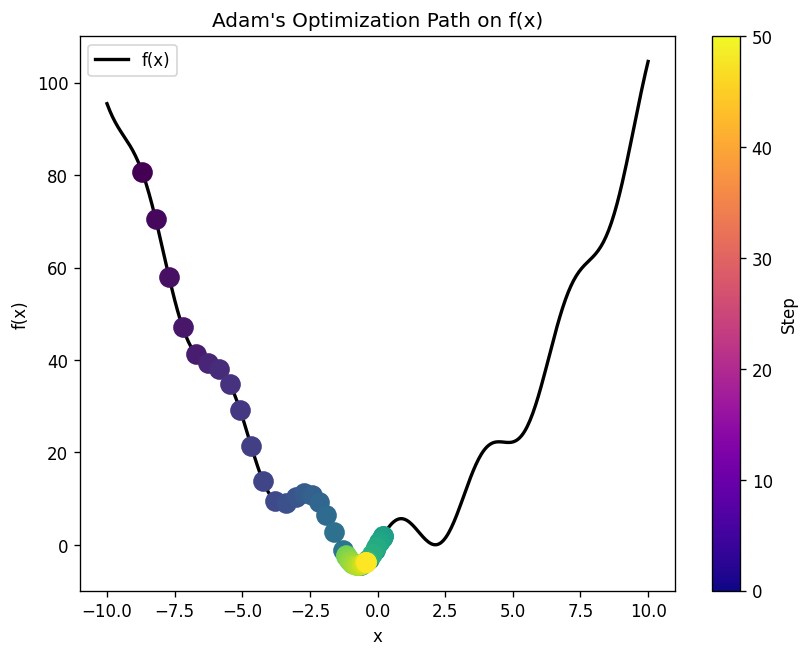

In [ ]:
#@title **Plot Adam Optimization Path**
plot_1d(adam_1d_data_trace, x_1d_range, "Adam's Optimization Path on f(x)")

## **1D Optimization using an LLM**

This series of cells performs 1D numerical optimization using an LLM as the update rule: at each iteration, the model receives the current state, proposes a new x-value, and the true function value f(x) is computed and fed back into the prompt for the next step. The process records each predicted (x, f(x)) pair along with the model’s explanation, building a trajectory of how the LLM explores the search space. This allows you to observe whether the LLM learns from the iterative feedback, improves its proposals over time, and moves toward lower function values in a manner comparable to traditional optimization algorithms. It then visualizes the LLM's trajectory on the 1D function using plot_1d, allowing you to see how the LLM navigates the landscape and converges toward a minimum.

In [ ]:
#@title **Training Sample for LLM 1D Optimization**
print(LLM_1D_Training_Samples)

x: -8.7
f(x): 80.653

x: -8.2
f(x): 70.431




In [ ]:
#@title **System Prompt for 1D Optimization**
LLM_1D_Training_Samples = ""
system_instruction = """
You are an expert optimization assistant, helping me find the global minimum of a mathematical function. I will give you the function evaluation f(x) and the current iteration number at each step. Your goal is to propose input values 'x' that efficiently lead us to the global minimum within a limited number of iterations (MAX_STEPS).

Here's how we'll interact:

1. I will first provide MAX_STEPS along with a few training examples of the form 'x, f(x)'.
2. You will provide your response in the following exact format:
    * Line 1: a new input 'x: ', aiming to minimize the function's value f(x). Choose x in range [-10,10]
    * Line 2: a brief explanation of why you chose that input in one sentence, considering the current iteration.
3. I will then provide the function's value f(x) at your suggested point, and the current iteration.
4. We will repeat steps 2-3 until we reach the maximum number of iterations.

Remember:

* **Assume no prior knowledge about the function's specific form.**
* **Balance Exploitation and Exploration:**  Early on, explore the input space broadly. As iterations increase, focus more on promising regions based on observed f(x) values.
* **Be adaptable:**  Your approach might need to change based on the function's behavior and the remaining iterations. If you suspect a local minimum or slow progress for too long, try more exploratory values and then exploit any promising findings based on your understanding of the function.
"""

context_1d = f"MAX_STEPS: {max_steps - num_train_samples}\n" + LLM_1D_Training_Samples

In [ ]:
#@title **LLM Numerical Optimization**
llm_1d_data_trace = []

for iter in range(max_steps - num_train_samples):
    time.sleep(2)
    try:
        response = client.models.generate_content(
            model=model_name,
            contents=[context_1d],
            config=types.GenerateContentConfig(
                thinking_config=types.ThinkingConfig(thinking_budget=0),
                system_instruction=system_instruction),
            )

        response_text = response.text

        llm_x = extract_llm_x(response_text)
        llm_explain = response_text.split('\n')[1]

        llm_x = float(llm_x)
        f_x = round(one_dimensional_function(torch.tensor([llm_x])).item(), 3)

        context_1d = f"step: {iter}\nx: {round(llm_x, 3)}\nf(x): {f_x}"

        llm_1d_data_trace.append((llm_x, f_x))

        print(f"Step: {iter}")
        print(f"llm_x: {llm_x}")
        print(f"f(x): {f_x}")
        print("LLM's Explanation:", llm_explain)
        print(" ")

    except Exception as e:
        print(f"Error at step {iter}: {e}")
        print("Pausing for 60 seconds before continuing...")
        time.sleep(60)
        continue


Step: 0
llm_x: 0.0
f(x): 0.0
LLM's Explanation: Explanation: Starting at the center of the search space to get an initial general idea of the function's behavior.
 
Step: 1
llm_x: 1.0
f(x): 5.546
LLM's Explanation: This initial step aims to explore the function's behavior in a positive direction from the origin.
 
Step: 2
llm_x: 0.0
f(x): 0.0
LLM's Explanation: This initial step explores the center of the range to get a broad understanding of the function's behavior.
 
Step: 3
llm_x: 1.0
f(x): 5.546
LLM's Explanation: This initial step explores a positive value to understand the function's behavior away from the origin.
 
Step: 4
llm_x: -1.0
f(x): -3.546
LLM's Explanation: This initial step aims to explore the opposite side of the input range to quickly understand the general trend of the function.
 
Step: 5
llm_x: 1.0
f(x): 5.546
LLM's Explanation: This initial step aims to explore the function's behavior on the opposite side of the input space relative to the first given point.
 
Ste

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.


KeyboardInterrupt



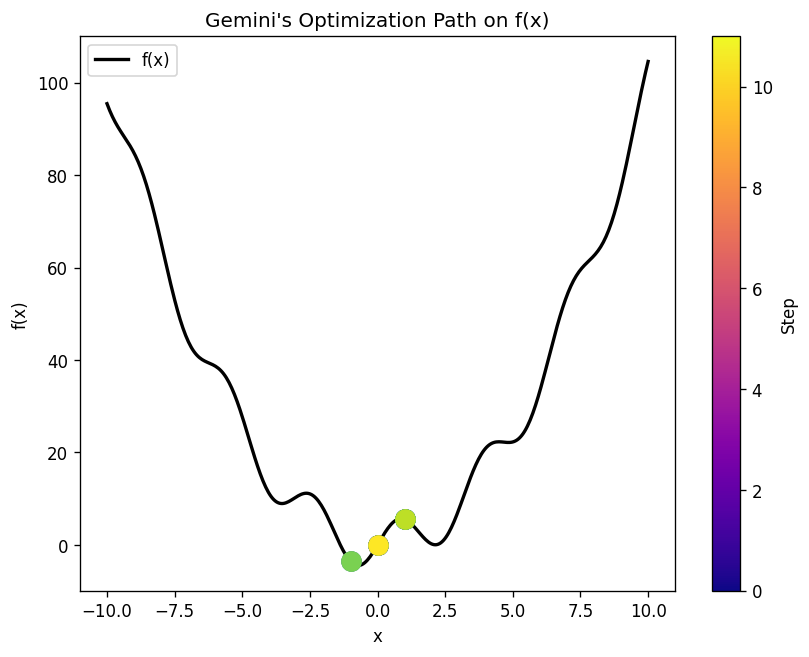

In [ ]:
#@title **Plot Gemini 1D Optimization Path**
plot_1d(llm_1d_data_trace, x_1d_range, "Gemini's Optimization Path on f(x)")

# **Part 2: Optimizing 2D Ackley Fuction**

The `Initial Values` cell is in charge of defining the initial start point (x,y) for the optimization problem and the amount of iterations to perform for optimization.

In [ ]:
#@title **Initial Values**
x_2d_range = (2, 12)
y_2d_range = (8, 19)

#Choose Custom Initial Point
initial_2dX = 7.319
initial_2dY = 8.299

# or Choose Random Initial Point from Range
# initial_2dX = round(random.uniform(x_2d_range[0], x_2d_range[1]),3)
# initial_2dY = round(random.uniform(y_2d_range[0], y_2d_range[1]),3)

max_steps = 100
num_train_samples = 2

print(f'Initial x: {initial_2dX} Initial y: {initial_2dY}')

Initial x: 7.319 Initial y: 8.299


## **2D Optimization using Adam**

This series of cells performs 2D optimization using the Adam optimizer by repeatedly updating a single variable, recording each step’s (x, y, f(x,y)) values. After completing the optimization loop, it visualizes Adam’s trajectory on the 2D function using plot_2d, allowing you to see how the optimizer navigates the landscape and converges toward a minimum.

In [ ]:
#@title **Optimize Ackley Using Adam**
x_2d = torch.tensor([initial_2dX], requires_grad=True)
y_2d = torch.tensor([initial_2dY], requires_grad=True)

learning_rate = 0.5
optimizer_2d = optim.Adam([x_2d,y_2d], lr=learning_rate)
adam_2d_data_trace = []
LLM_2D_Training_Samples = ""
for step in range(max_steps):
    optimizer_2d.zero_grad()
    loss = shifted_ackley(x_2d, y_2d)

    if step < num_train_samples:
        LLM_2D_Training_Samples+= f"x: {round(x_2d.item(),3)} y: {round(y_2d.item(), 3)}\nf(x,y): {round(loss.item(),3)}\n\n"
    adam_2d_data_trace.append((x_2d.item(), y_2d.item(), loss.item()))
    loss.backward()
    optimizer_2d.step()
print(f"Adam's Results:\nBest x: {x_2d.item()}, Best y: {y_2d.item()}, Best f(x,y): {loss.item()}")


Adam's Results:
Best x: 7.007384777069092, Best y: 8.016058921813965, Best f(x,y): 13.17922592163086


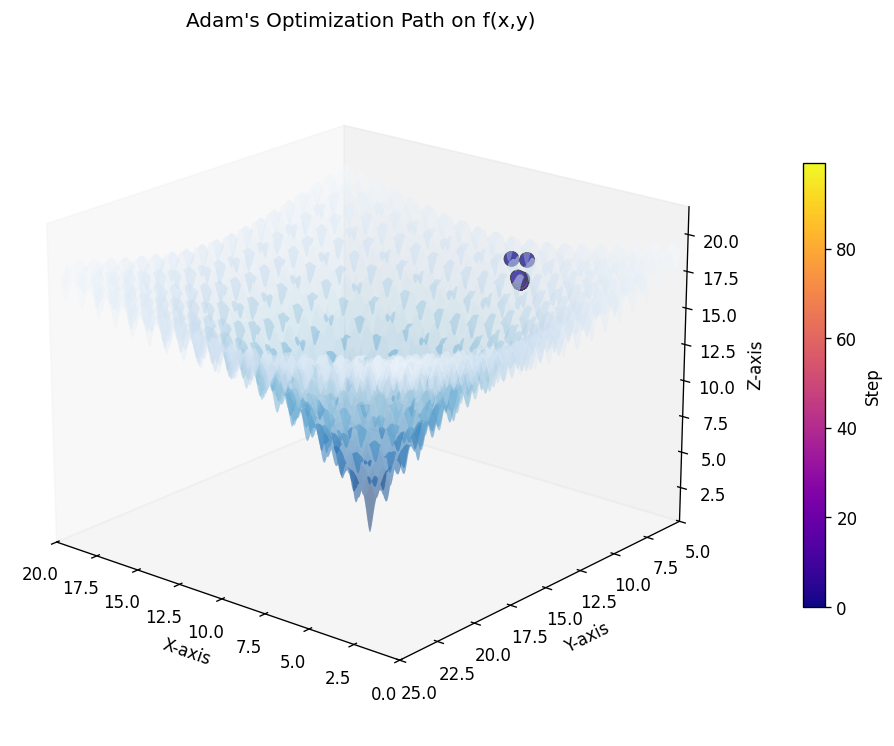

In [ ]:
#@title **Plot Adam Optimization Path**
plot_2d(adam_2d_data_trace, azim=130, title="Adam's Optimization Path on f(x,y)")

In [ ]:
#@title **Training Sample for 2D Optimization**
print(LLM_2D_Training_Samples)

x: 7.319 y: 8.299
f(x,y): 14.815

x: 6.819 y: 7.799
f(x,y): 14.713




## **2D Optimization using an LLM**

This series of cells performs 2D numerical optimization using an LLM as the update rule: at each iteration, the model receives the current state, proposes a new x-value and y-value, and the true function value f(x,y) is computed and fed back into the prompt for the next step. The process records each predicted (x, y f(x,y)) pair along with the model’s explanation, building a trajectory of how the LLM explores the search space. This allows you to observe whether the LLM learns from the iterative feedback, improves its proposals over time, and moves toward lower function values in a manner comparable to traditional optimization algorithms. It then visualizes the LLM's trajectory on the 1D function using plot_1d, allowing you to see how the LLM navigates the landscape and converges toward a minimum.

In [ ]:
#@title **System Prompt for 2D Optimization**
LLM_2D_Training_Samples = ""
system_instruction_2 = """You are an optimization assistant, helping me find the global minimum of a mathematical function.  I will give you the function evaluation and the current iteration number at each step. Your goal is to propose input values that efficiently lead us to the global minimum within a limited number of iterations (MAX_STEPS).

Here's how we'll interact:

1. I will first provide MAX_STEPS along with few training examples.
2. You will provide your response in the following exact format:
    * Line 1: a new input 'x: , y: ', aiming to minimize the function's value f(x,y). Choose x is range [2,12] and y in [8,19]
    * Line 2: a brief (one sentence) explanation of why you chose that input, considering the current iteration.
3. I will then provide the function's value f(x,y) at that point, and the current iteration.
4. We will repeat steps 2-3 until we reach the maximum number of iterations.

Remember:

* **Assume no prior knowledge about the function's specific form.**
* **Balance Exploitation and Exploration:**  Early on, explore broadly. As iterations increase, focus more on promising regions.
* **Be adaptable:**  Your approach might need to change based on the function's behavior and the remaining iterations. If you think you are stuck in a local minima or making small increments for too long, try more exploratory values and then eventually exploit new values based on your understanding of the function.

"""

context_2d = f"MAX_STEPS: {max_steps - num_train_samples}\n" + LLM_2D_Training_Samples # Inital Context for Gemini

In [ ]:
#@title **Optimization**
llm_2d_data_trace = []

for iter in range(max_steps - num_train_samples):
    try:
        response = client.models.generate_content(
            model=model_name,
            contents=[context_2d],
            config=types.GenerateContentConfig(
                thinking_config=types.ThinkingConfig(thinking_budget=0),
                system_instruction=system_instruction_2
            ),
        )

        response_text = response.text.strip()

        llm_xy = extract_llm_xy(response_text)
        llm_explain = response_text.split('\n')[1] if '\n' in response_text else ""

        llm_x = float(llm_xy[0])
        llm_y = float(llm_xy[1])

        f_xy = shifted_ackley(torch.tensor([llm_x]), torch.tensor([llm_y])).item()

        context_2d = (
            f"step: {iter}\n"
            f"x: {round(llm_x, 3)} y: {round(llm_y, 3)}\n"
            f"f(x,y): {round(f_xy, 3)}"
        )

        llm_2d_data_trace.append((llm_x, llm_y, f_xy))

        print(f"Step: {iter}")
        print(f"llm_x: {llm_x}")
        print(f"llm_y: {llm_y}")
        print(f"f(x,y): {f_xy}")
        print("LLM's Output:", response_text)
        print(" ")

    except Exception as e:
        print(f"Error at step {iter}: {e}")
        print("Pausing for 60 seconds before continuing...")
        time.sleep(60)
        continue


Step: 0
llm_x: 7.0
llm_y: 13.5
f(x,y): 9.27238941192627
LLM's Output: x: 7.0, y: 13.5
Explanation: Starting with a central point to get an initial evaluation of the function's behavior in the middle of the search space.
 
Step: 1
llm_x: 7.0
llm_y: 13.5
f(x,y): 9.27238941192627
LLM's Output: x: 7.0, y: 13.5
This initial point is chosen to be in the center of the search space, providing a balanced starting point for exploration.
 
Step: 2
llm_x: 9.0
llm_y: 16.0
f(x,y): 3.6253862380981445
LLM's Output: x: 9.0, y: 16.0
I chose this input to explore a different region of the search space, moving towards higher x and y values, to get a broader understanding of the function's landscape.
 
Step: 3
llm_x: 7.0
llm_y: 13.0
f(x,y): 7.988910675048828
LLM's Output: x: 7.0, y: 13.0
This point is chosen as a step towards the center of the domain, exploring the function's behavior in a new region after the initial evaluation.
 
Step: 4
llm_x: 9.0
llm_y: 15.0
f(x,y): 2.6375322341918945
LLM's Output: x: 

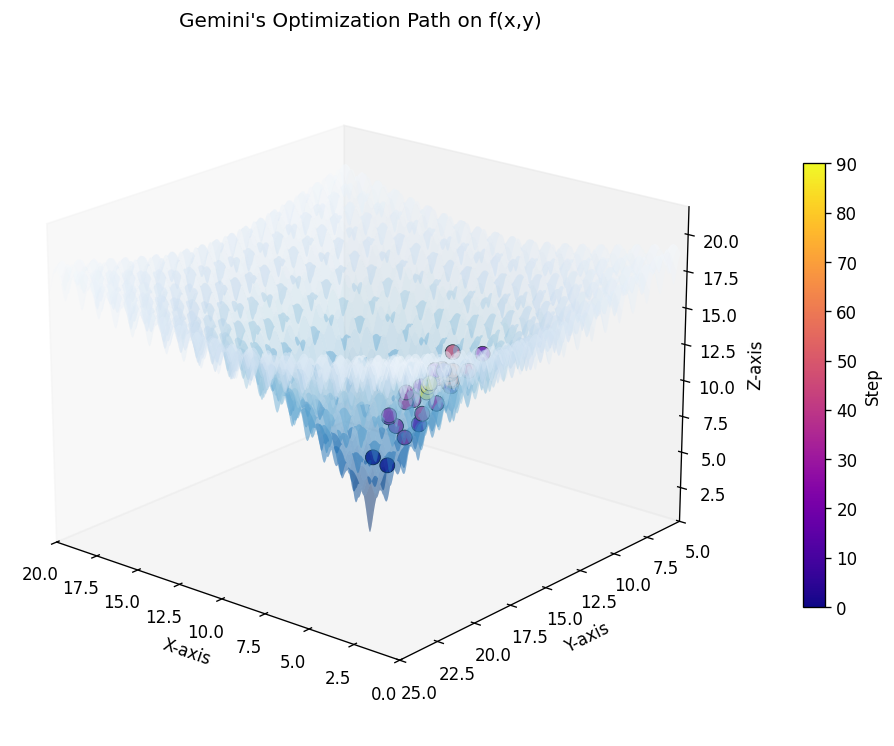

In [ ]:
#@title **Plot Gemini 2D Optimization Path**
plot_2d(llm_2d_data_trace, azim=130, title="Gemini's Optimization Path on f(x,y)")

# **Part 3: Comparing Results from Adam, the LLM, and other Baselines**

## **1D Baselines & Comparisons**

In [ ]:
#@title **1D Initial f(x)**
init_1d_fx = one_dimensional_function(torch.tensor(Initial_1d_x)).item()
print('Inital F(x):', round(init_1d_fx,3))

Inital F(x): 80.653


In [ ]:
#@title **1D Nelder Mead**
best_nm_1d = optimize_with_nelder_mead(one_dimensional_function, [Initial_1d_x], max_iter=100).fun
print("Nelder Mead's Best:", round(best_nm_1d,3))

Nelder Mead's Best: -4.439


In [ ]:
#@title **1D Gradient Descent**
best_gd_1d = optimize_gd([Initial_1d_x], one_dimensional_function, MAX_STEPS=max_steps)
print("Gradient Descent's Best:", round(best_gd_1d,3))

Gradient Descent's Best: 11.96


In [ ]:
#@title **1D Adam**
best_adam_1d = adam_1d_data_trace[-1][1]
print("Adam's Best:", round(best_adam_1d ,3))

Adam's Best: -4.435


In [ ]:
#@title **1D Gemini-2.5-Flash**
best_llm_1d = llm_1d_data_trace[-1][1]
print("Gemini's Best:", round(best_llm_1d ,3))

Gemini's Best: -4.3


## **2D Baselines & Comparisons**

In [ ]:
#@title **2D Initial f(x,y)**
init_2d_fx = shifted_ackley(torch.tensor(initial_2dX), torch.tensor(initial_2dY)).item()
print('Inital F(x,y):', round(init_2d_fx,3))

Inital F(x,y): 14.815


In [ ]:
#@title **2D Nelder Mead**
init_2dx = np.array([initial_2dX, initial_2dY])
best_nm_2d = optimize_with_nelder_mead(shifted_ackley, init_2dx , max_iter=max_steps).fun
print("Nelder Mead's Best:", round(best_nm_2d,3))

Nelder Mead's Best: 11.811


In [ ]:
#@title **2D Gradient Descent**
init_2dx = np.array([initial_2dX, initial_2dY])
best_gd_2d = optimize_gd(init_2dx, shifted_ackley, MAX_STEPS=max_steps)
print("Gradient Descent's Best:", round(best_gd_2d,3))

Gradient Descent's Best: 13.179


In [ ]:
#@title **2D Adam**
best_adam_2d = adam_2d_data_trace[-1][2]
print("Adam's Best:", round(best_adam_2d ,3))

Adam's Best: 13.179


In [ ]:
#@title **2D Gemini-2.5-Flash**
best_llm_2d = llm_2d_data_trace[-1][2]
print("Gemini's Best:", round(best_llm_2d ,3))

Gemini's Best: 7.212


## **Summary**
This tutorial illustrates how LLMs can perform numerical optimization on both 1D and 2D objective functions by iteratively proposing improved parameter values using only function evaluations embedded within the prompt. By supplying the model with initial samples, the history of previously attempted x or (x, y) values, and their corresponding objective values on functions like the 1D Ackley variant and the shifted 2D Ackley function, the LLM infers patterns in the landscape and adjusts its proposed values over time—without being given gradients or any explicit optimization rules. Each iteration provides fresh contextual feedback derived from real function outputs, allowing the LLM to refine its predictions step-by-step in a manner similar to classical optimizers. Through this setup, we observe the emergence of a “textual gradient,” where the model leverages contextual reasoning to move toward better solutions, providing a gradient-free optimization strategy driven entirely by the prompt.

Beyond this specific demonstration, the same approach can extend to a broad range of numerical reasoning and model-based optimization tasks. Embedding execution traces, intermediate values, or feedback signals directly into the prompt enables LLMs to iteratively tune continuous parameters, explore complex landscapes, or adapt strategies across different domains. These variations highlight how prompt-structured feedback loops can unlock optimization capabilities in LLMs, allowing them to operate as general-purpose numerical optimizers even in the absence of analytic derivatives or algorithmic instructions.

## **Conclusion**
This demonstration shows that LLMs can serve as effective gradient-free optimizers when guided through iterative prompting, capturing the essence of optimization-by-feedback in both 1D and 2D settings. Without access to gradient information, update equations, or traditional optimization heuristics, the LLM improves its proposed x and (x, y) values solely from the pattern of past inputs and objective outputs, progressively moving toward lower-value regions of the Ackley landscapes. Although the model is not computing true gradients internally, its ability to approximate better parameter choices from contextual information supports the core insight: LLMs can perform meaningful numerical optimization when supplied with structured iterative feedback. Our experiments comparing LLM behavior with Adam, Gradient Descent, and Nelder–Mead validate this idea and demonstrate that LLM-driven optimization is both feasible and interpretable, offering a practical way to explore optimization dynamics using language as the feedback medium.

<br>

For more details, please refer to the [SAS-Prompt Project Page](https://sites.google.com/asu.edu/sas-llm/) and the associated [research paper](https://arxiv.org/pdf/2504.20459)

## **References**
Ben Amor, H., Graesser, L., Iscen, A., D’Ambrosio, D., Abeyruwan, S., Bewley, A., Zhou, Y., Kalirathinam, K., Mishra, S., & Sanketi, P. (2025, May). SAS-prompt: Large Language Models as Numerical Optimizers for Robot Self-Improvement. In *2025 IEEE International Conference on Robotics and Automation (ICRA)* (pp. 10087-10094). IEEE.